## About

This page showcases the work of [Claus O. Wilke](https://clauswilke.com/) in his R package [practicalgg](https://wilkelab.org/practicalgg/index.html) that contains step-by-step examples demonstrating how to get the most out of ggplot2. You can find the original [R](https://www.r-graph-gallery.com/) code for this example [here](https://wilkelab.org/practicalgg/articles/corruption_human_development.html). 

Thanks to him for accepting sharing his work here! Thanks also to [Tomás Capretto](https://tcapretto.netlify.app/) who translated this work from R to Python! 🙏🙏

As a teaser, here is the plot we’re gonna try building:

<img src="https://wilkelab.org/practicalgg/articles/corruption_human_development_files/figure-html/unnamed-chunk-10-1.png" width="95%"/>




## Load libraries

In addition to Matplotlib, today's chart also uses [`adjustText`](https://github.com/Phlya/adjustText) to automatically adjust the position of labels in the plot, and [`scikit-learn`](https://scikit-learn.org/stable/) to obtain a linear regression fit.

>Note: the `adjustText` library can be installed with `pip install adjustText`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from adjustText import adjust_text
from matplotlib.lines import Line2D # for the legend
from sklearn.linear_model import LinearRegression

## Load and prepare data

Today's chart uses the [`corruption`](https://wilkelab.org/practicalgg/reference/corruption.html) dataset in the practicalgg package. This data contains information about Corruption Perceptions Index (CPI) and Human Development Index (HDI) for 176 countries, from 2012 to 2015. 

The original source are the [Corruption Perceptions Index 2016](https://www.transparency.org/en/news/corruption-perceptions-index-2016#table) released by [Transparency International](https://transparency.org) and the [Human Development Index](http://hdr.undp.org/en/data#) made available in the 
[Human Development Reports](http://hdr.undp.org/en/) by the [United Nations Development Programme](https://www.undp.org/). These datasets were merged and made available by [Claus O. Wilke](https://clauswilke.com/) as the `corruption` dataset in his `practicalgg` package. Thanks to Claus for all the work and making this possible!

In [2]:
corruption = pd.read_csv("../../static/data/corruption.csv")

The next step is to keep only observations for the 2015 year and drop any row that contains a missing value.

In [3]:
corrupt = corruption.query("year == 2015").dropna()
corrupt.head()

,country,region,year,cpi,iso3c,hdi
0,Denmark,Europe and Central Asia,2015,91.0,DNK,0.925
1,New Zealand,Asia Pacific,2015,91.0,NZL,0.915
2,Finland,Europe and Central Asia,2015,90.0,FIN,0.895
3,Sweden,Europe and Central Asia,2015,89.0,SWE,0.913
4,Switzerland,Europe and Central Asia,2015,86.0,CHE,0.939


## Basic Scatterplot

Let's get started by creating a very basic scatterplot to show the relationship between the Corruption Perceptions Index and the Human Development Index.

In [4]:
CPI = corrupt["cpi"].values
HDI = corrupt["hdi"].values

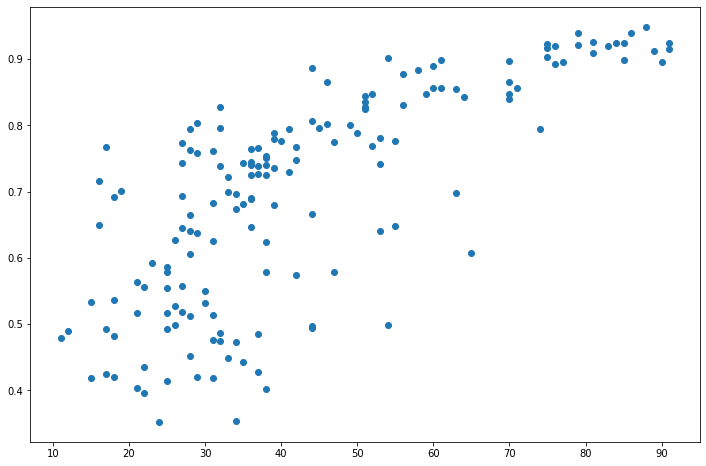

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(CPI, HDI);

>It's also possible to use `ax.scatter("cpi", "hdi", data=corrupt)` 

Albeit being simple, the plot above is enough to see there's a positive association between the two indexes under study. 

But this is just the start, let's make it better!

## Customize marker colors 

The next step is to use a different color for each region so it is possible to see the association between the region, the Corrupt Perceptions Index, and the Human Development Index.

As its name says, the following function can be used to adjust the lightness of a color. The `amount` argument controls this adjustment. Values below 1 mean the color darkens, while values above 1 indicate the color is lightened.

In [6]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

Now let's select the colors for fill and the edges:

In [7]:
# Okabe Ito colors
REGION_COLS = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]

# Category values for the colors
CATEGORY_CODES = pd.Categorical(corrupt["region"]).codes

# Select colors for each region according to its category.
COLORS = np.array(REGION_COLS)[CATEGORY_CODES]

# Compute colors for the edges: simply darker versions of the original colors
EDGECOLORS = [adjust_lightness(color, 0.6) for color in COLORS] 

And make a new plot:

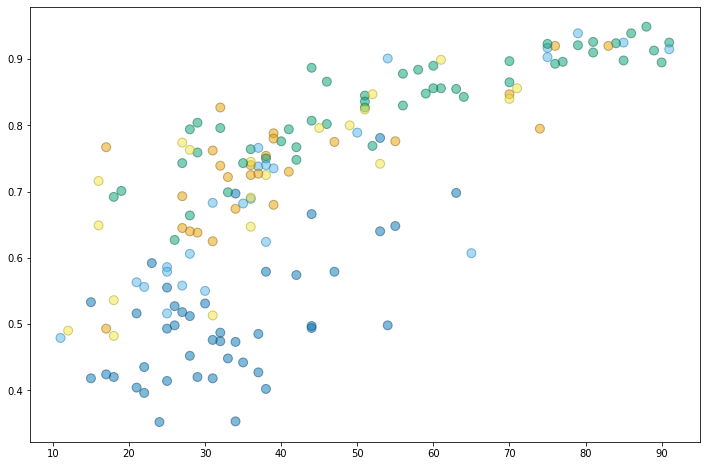

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(
    CPI, HDI, color=COLORS, edgecolors=EDGECOLORS,
    s=80, alpha=0.5, zorder=10
);
# zorder = 10 is used to make sure markers are on top of the regression line added later

Both the transparency set on the markers and the darker edge color make it easier to differentiate the different dots, especially when there is some overlap.

## Add regression line

It has been a good choice to use colors. The chart is now more beautiful and more insightful. That's great!

The next step is to add a regression line that shows the relationship between the Corruption Perceptions Index and the Human Development Index. As you may see from the chart above, the relationship is not linear. The following chunk uses `scikit-learn` to fit a linear regression between the logarithm of CPI (predictor) and HDI (response). Some details about the implementation are explained in the comments.

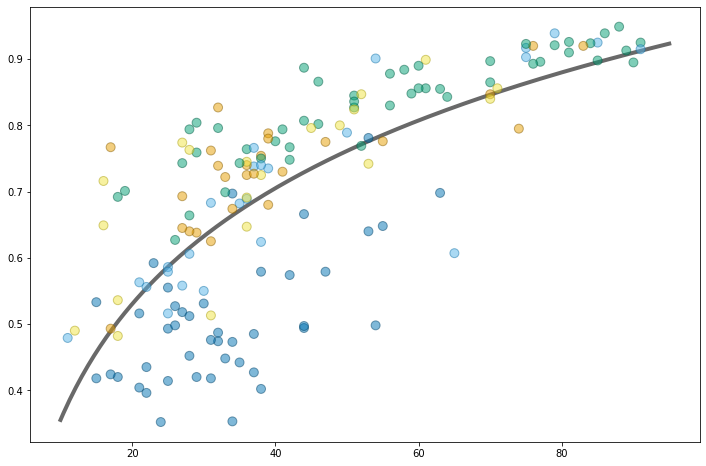

In [9]:
# Some notes: 
# * scikit-learn asks 2-dimensional arrays for X, that's why the reshape
# * The response, y, does not need to be 2-dimensional
X = CPI.reshape(-1, 1)
y = HDI

# Initialize linear regression object
linear_regressor = LinearRegression()

# Fit linear regression model of HDI on the log of CPI
linear_regressor.fit(np.log(X), y)

# Make predictions
# * Construct a sequence of values ranging from 10 to 95 and
#   apply logarithmic transform to them.
x_pred = np.log(np.linspace(10, 95, num=200).reshape(-1, 1))

# * Use .predict() method with the created sequence
y_pred = linear_regressor.predict(x_pred)  

# Plot regression line.
# * Logarithmic transformation is reverted by using the exponential one.
ax.plot(np.exp(x_pred), y_pred, color="#696969", lw=4)
fig

Voilà! There we have our line of best fit. It certainly helps to see the relationship between the two variables in the chart.

## Customize layout

Making a good visualization isn't just about beautiful colors and shapes. The layout is very important too. A good layout not only makes the plot more attractive, but it also makes it more informative.

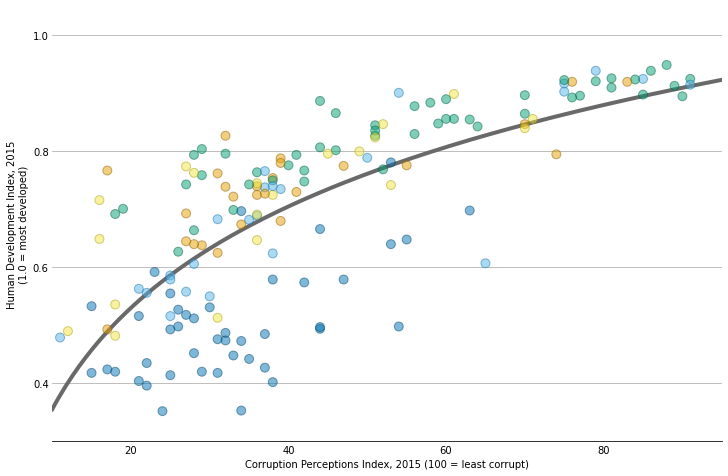

In [10]:
# Set default font size to 16
plt.rcParams.update({"font.size": "16"})

# Set y limits and y ticks
ax.set_ylim(0.3, 1.05)
ax.set_yticks([0.4, 0.6, 0.8, 1.0])

# Set x limits and x ticks
ax.set_xlim(10, 95)
ax.set_xticks([20, 40, 60, 80])

# Remove tick marks on both x and y axes
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

# Add grid lines, only for y axis
ax.grid(axis="y")

# Remove all spines but keep the bottom one
ax.spines["left"].set_color("none")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# And finally set labels
ax.set_xlabel("Corruption Perceptions Index, 2015 (100 = least corrupt)")
ax.set_ylabel("Human Development Index, 2015\n(1.0 = most developed)")

fig

It's wonderful to see how some tiny adjustments add up to a much cleaner and clearer visualisation!

## Add legends

What do the colors mean? What does the grey line represent? Unless you see the code used to create the plot, it's impossible to answer those questions. 

What's truly missing here is a __legend__. Let's create one that adds circular markers as well as a line to represent the regression fit.

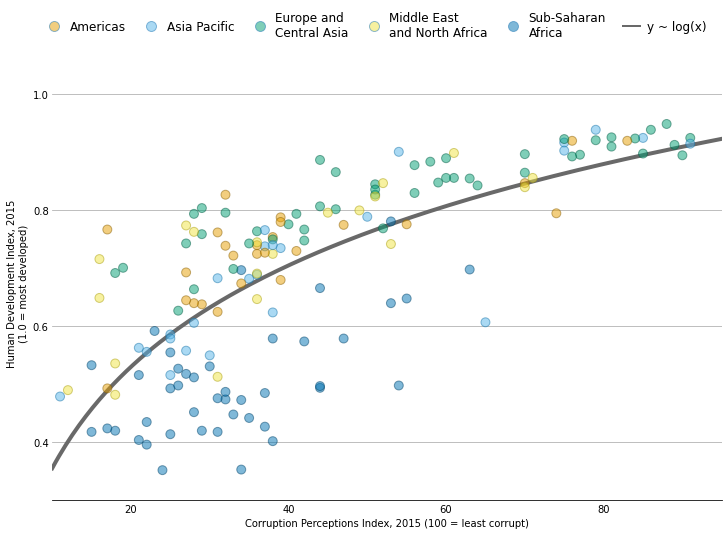

In [11]:
# Create handles -------------------------------------------------
# Region names with linebreaks for the long ones
REGIONS = [
    "Americas", "Asia Pacific", "Europe and\nCentral Asia", 
    "Middle East\nand North Africa", "Sub-Saharan\nAfrica"
]

# Create handles for lines.
handles = [
    Line2D(
        [], [], label=label, 
        lw=0, # there's no line added, just the marker
        marker="o", # circle marker
        markersize=10, 
        markerfacecolor=REGION_COLS[idx], # marker fill color
    )
    for idx, label in enumerate(REGIONS)
]

# Append a handle for the line
handles += [Line2D([], [], label="y ~ log(x)", color="#696969", lw=2)]

# Add legend -----------------------------------------------------
legend = fig.legend(
    handles=handles,
    bbox_to_anchor=[0.5, 0.95], # Located in the top-mid of the figure.
    fontsize=12,
    handletextpad=0.6, # Space between text and marker/line
    handlelength=1.4, 
    columnspacing=1.4,
    loc="center", 
    ncol=6,
    frameon=False
)

# Set transparency -----------------------------------------------
# Iterate through first five handles and set transparency
for i in range(5): 
    handle = legend.legendHandles[i]
    handle._legmarker.set_alpha(0.5)

fig

## Add labels with no overlap

The last step is to add labels to identify the countries behind some data points.

It is pretty challenging to add many labels on a plot since labels tend to overlap each other, making the figure unreadable. Fortunately, the `adjustText` package is here to help. It provides an algorithm that will automatically place the labels for us. Let's do it!

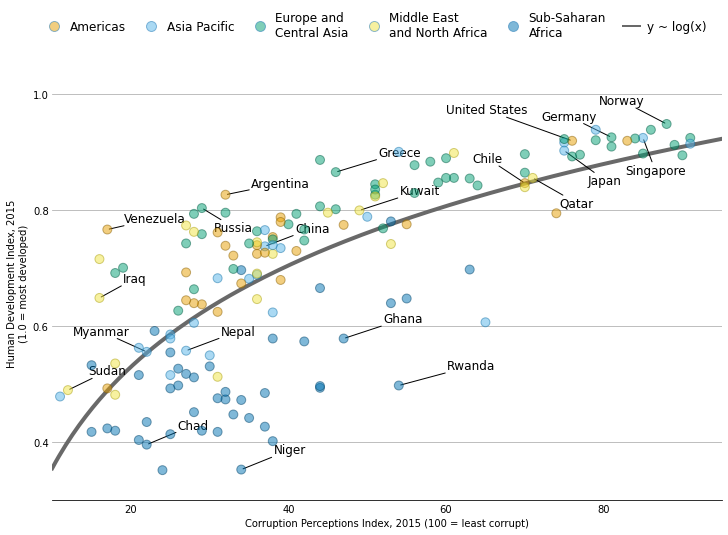

<Figure size 432x288 with 0 Axes>

In [12]:
# Specify countries ----------------------------------------------
# All the countries, in the order they appear in the dataset 
COUNTRIES = corrupt["country"].values

# Countries that are going to be highlighted
COUNTRY_HIGHLIGHT = [
    "Germany", "Norway", "United States", "Greece", "Singapore", 
    "Rwanda", "Russia", "Venezuela", "Sudan", "Iraq", "Ghana", 
    "Niger", "Chad", "Kuwait", "Qatar",     "Myanmar", "Nepal", 
    "Chile", "Argentina", "Japan", "China"
]


# Add labels -----------------------------------------------------
# Iterate through all the countries in COUNTRIES
# `ax.text()` outputs are appended to the `TEXTS` list. 
# This list is passed to `adjust_text()` to adjust the position of
# the legends and add connecting lines
TEXTS = []
for idx, country in enumerate(COUNTRIES):
    # Only append selected countries
    if country in COUNTRY_HIGHLIGHT:
        x, y = CPI[idx], HDI[idx]
        TEXTS.append(ax.text(x, y, country, fontsize=12))

# Adjust text position and add lines -----------------------------
# 'expand_points' is a tuple with two multipliers by which to expand
# the bounding box of texts when repelling them from points

# 'arrowprops' indicates all the properties we want for the arrows
# arrowstyle="-" means the arrow does not have a head (it's just a line!)
adjust_text(
    TEXTS, 
    expand_points=(3, 3),
    arrowprops=dict(arrowstyle="-", lw=1),
    ax=ax
)

# Save it! -------------------------------------------------------
# Optional:
# ax.set_facecolor("white") # set axis background color to white
# fig.set_facecolor("white") # set figure background color to white
# fig.savefig("plot.png", dpi=300)

fig